In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/processed_tweet.csv")

# Calculate TF-IDF

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
df = df[df["text"].notnull()]
idx = df.index
df.reset_index(drop=True, inplace=True)

In [5]:
text = df["text"]
vectoriser = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
matrix = vectoriser.fit_transform(text)

In [6]:
matrix.shape

(6436, 1046)

# Dimension Reduction

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [8]:
pipe = Pipeline([
    ('pca', PCA())
])

In [9]:
param_grid = {
    'pca__n_components': [10, 50, 100, 150, 200, 300, 400, 500]
}

search = GridSearchCV(pipe, param_grid, cv=3)
search.fit(matrix.toarray())

print(f"Best number of PCA components: {search.best_params_['pca__n_components']}")

Best number of PCA components: 150


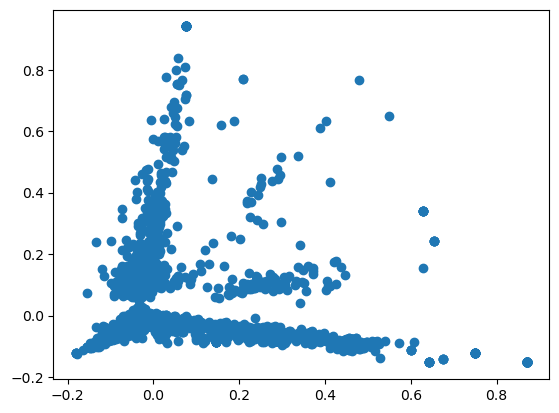

In [10]:
pca = PCA(n_components=search.best_params_['pca__n_components'])
matrix_pca = pca.fit_transform(matrix.toarray())
plt.scatter(matrix_pca[:, 0], matrix_pca[:, 1])
plt.show()

# Find Best K for KMeans Clustering

## Elbow Method

In [11]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

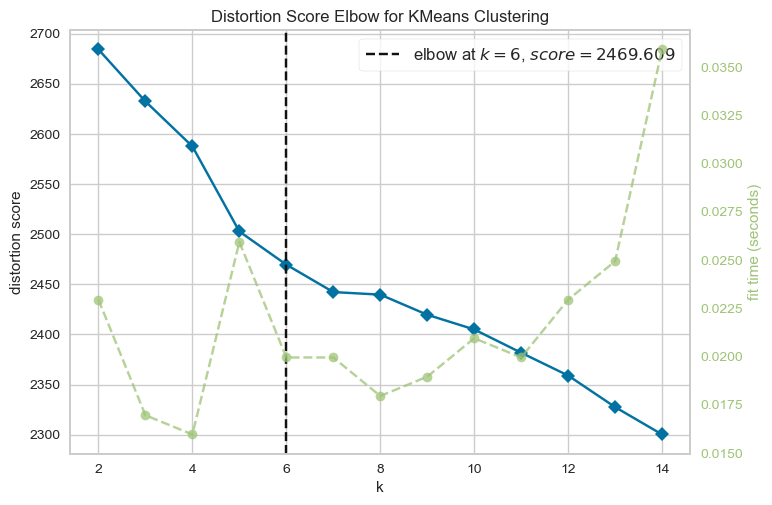

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
visualizer = KElbowVisualizer(KMeans(random_state=2043), k=(2, 15))  # k=(2, 15) means it will test clusters from 2 to 15
visualizer.fit(matrix_pca)  # Fit the data (TF-IDF matrix)
visualizer.show()  # Display the elbow plot

## Silhouette Score

In [13]:
from sklearn.metrics import silhouette_score

In [14]:
k_values = range(2, 10)
silhouette_scores = []
best_k = None
best_silhouette_score = -1

for k in k_values:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10,
                max_iter=100, random_state=2043)
    km.fit(matrix_pca)
    
    silhouette_avg = silhouette_score(matrix_pca, km.labels_)
    silhouette_scores.append(silhouette_avg)
    
    if silhouette_avg > best_silhouette_score:
        best_k = k
        best_silhouette_score = silhouette_avg

print("Best K value:", best_k)
print("Best Silhouette Score:", best_silhouette_score)

Best K value: 2
Best Silhouette Score: 0.13309014073720324


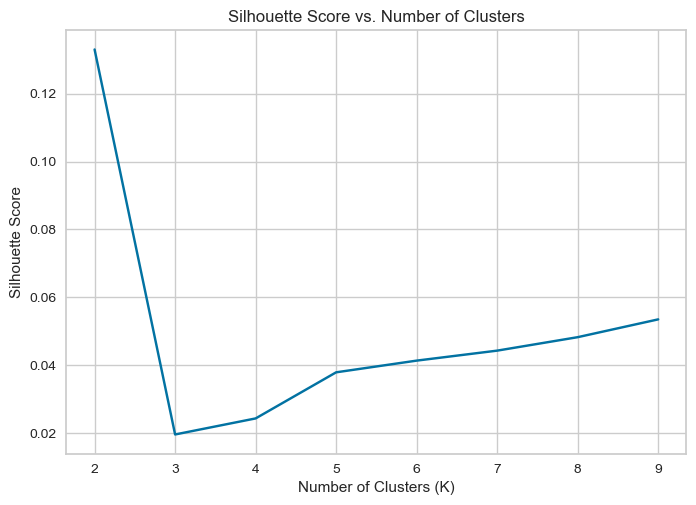

In [15]:
plt.plot(k_values, silhouette_scores)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.show()

# Putting Everything Together

In [16]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=2043)
kmeans.fit(matrix)

df['theme'] = kmeans.labels_

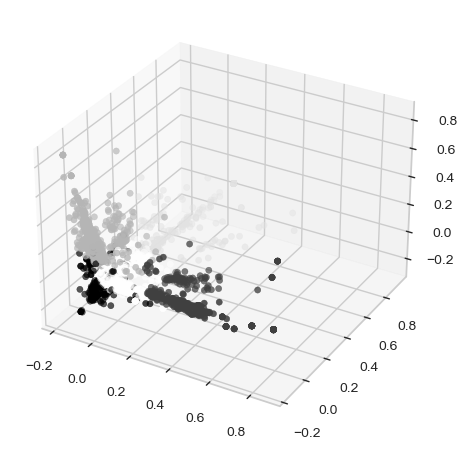

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(matrix_pca[:, 0], matrix_pca[:, 1], matrix_pca[:,2],c=kmeans.labels_)
plt.show()

In [18]:
# Raw Data
tweets = pd.read_csv("data/tweets.csv")
tweets = tweets.loc[idx].reset_index(drop=True)
tweets["theme"] = df["theme"]

In [19]:
# Store each numbered theme separately to make topic analysis easier.
for i in range(n_clusters):
    tweet_theme = tweets[tweets["theme"] == i]
    tweet_theme.to_csv(f"data/themes/theme_{i}.csv", index=False)

In [20]:
# After topic analysis, map topic to tweet
topics = {0: "Election/Policy",
         1: "America",
         2: "Donald Trump",
         3: "Taxes/Economy",
         4: "Acknowledgement",
         5: "Hilary Clinton"}

# tweets["topic"] = np.zeros(len(tweets))
tweets["topic"] = tweets["theme"].map(topics)

In [21]:
tweets.to_csv("data/tweets_wtopics.csv", index=False)